<a href="https://colab.research.google.com/github/YianKim/2022_PythonStudy_face_emotion_recognition/blob/main/GAN_fer2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import argparse

import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import BatchNormalization
from keras.datasets import mnist
from keras import optimizers
from keras import initializers
from keras import backend as K
import PIL
import pickle
import random

K.set_image_data_format('channels_first')

In [2]:
def load_data(dataset_path):
  
  #classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprsie', 'Neutral']

  data = []
  test_data = []
  test_labels = []
  labels =[]

  with open(dataset_path, 'r') as file:
      for line_no, line in enumerate(file.readlines()):
          if 0 < line_no <= 35887:
            curr_class, line, set_type = line.split(',')
            image_data = np.asarray([int(x) for x in line.split()]).reshape(48, 48)
            image_data =image_data.astype(np.uint8)/255.0

            if (set_type.strip() == 'PrivateTest'):
              
              test_data.append(image_data)
              test_labels.append(curr_class)
            else:
              data.append(image_data)
              labels.append(curr_class)
      
      test_data = np.expand_dims(test_data, -1)
      test_labels = to_categorical(test_labels, num_classes = 7)
      data = np.expand_dims(data, -1)   
      labels = to_categorical(labels, num_classes = 7)
    
      return np.array(data), np.array(labels), np.array(test_data), np.array(test_labels)

dataset_path = "/content/drive/MyDrive/파이썬스터디 프로젝트/fer2013.csv/fer2013.csv"
train_data, train_labels, test_data, test_labels = load_data(dataset_path)
#train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = test_size,random_state = seed)

#평가용
test_labels2 = np.argmax(test_labels, axis=1)

# print("Number of images in Training set:", len(train_data))
# print("Number of images in Test set:", len(test_data))

with open('/content/drive/MyDrive/파이썬스터디 프로젝트/aug_array1.pkl', 'rb') as f:
	aug_array1 = pickle.load(f)
 
train_data_aug = np.concatenate((train_data, aug_array1), axis=0).reshape([-1,48,48])
train_labels_aug = np.concatenate((train_labels, train_labels), axis=0)

In [3]:
trl = []
for i in train_labels_aug:
  trl.append(i.tolist().index(1))
tel = []
for i in test_labels:
  tel.append(i.tolist().index(1))

In [26]:
class Data:
    """
    Define dataset for training GAN
    """
    def __init__(self, batch_size, z_input_dim):
        # load mnist dataset
        # 이미지는 보통 -1~1 사이의 값으로 normalization : generator의 outputlayer를 tanh로
        (X_train, y_train), (X_test, y_test) = (train_data_aug, trl), (test_data, tel)
        self.x_data = ((X_train - 0.5) * 2)
        self.x_data = self.x_data.reshape((self.x_data.shape[0], 1) + self.x_data.shape[1:])
        self.batch_size = batch_size
        self.z_input_dim = z_input_dim

    def get_real_sample(self):
        """
        get real sample mnist images

        :return: batch_size number of mnist image data
        """
        return self.x_data[np.random.randint(0, self.x_data.shape[0], size=self.batch_size)]

    def get_z_sample(self, sample_size):
        """
        get z sample data

        :return: random z data (batch_size, z_input_dim) size
        """
        return np.random.uniform(-1.0, 1.0, (sample_size, self.z_input_dim))

In [27]:
class GAN:
    def __init__(self, learning_rate, z_input_dim):
        """
        init params

        :param learning_rate: learning rate of optimizer
        :param z_input_dim: input dim of z
        """
        self.learning_rate = learning_rate
        self.z_input_dim = z_input_dim
        self.D = self.discriminator()
        self.G = self.generator()
        self.GD = self.combined()

    def discriminator(self):
        """
        define discriminator
        """
        D = Sequential()
        D.add(Conv2D(256, (5, 5),
                     padding='same',
                     input_shape=(1, 48, 48),
                     #정규분포를 가진 임의 가중치 초기화(stddev는 표준편차)
                     kernel_initializer=initializers.RandomNormal(stddev=0.02)))
        D.add(LeakyReLU(0.2))
        D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
        D.add(Dropout(0.3))
        D.add(Conv2D(512, (5, 5), padding='same'))
        D.add(LeakyReLU(0.2))
        D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
        D.add(Dropout(0.3))
        D.add(Flatten())
        D.add(Dense(256))
        D.add(LeakyReLU(0.2))
        D.add(Dropout(0.3))
        D.add(Dense(1, activation='sigmoid'))
        # output : 진짜 / 가짜 : 1 (sigmoid를 통해 0.5 기준으로 classification)
        adam = keras.optimizers.Adam(lr=self.learning_rate, beta_1=0.5)
        D.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        return D

    def generator(self):
        """
        define generator
        """

        G = Sequential()
        #512는 출력뉴런의 수, input_dim은 입력뉴런의 수
        G.add(Dense(512, input_dim=self.z_input_dim))
        G.add(LeakyReLU(0.2))
        G.add(Dense(128 * 12 * 12))
        G.add(LeakyReLU(0.2))
        G.add(BatchNormalization())
        # reshape하면 output shape 형태 (batch_size,) + target_shape
        G.add(Reshape((128, 12, 12), input_shape=(128 * 12 * 12,)))
        G.add(UpSampling2D(size=(2, 2)))
        G.add(Conv2D(64, (5, 5), padding='same', activation='tanh'))
        G.add(UpSampling2D(size=(2, 2)))
        G.add(Conv2D(1, (5, 5), padding='same', activation='tanh'))

        adam = keras.optimizers.Adam(lr=self.learning_rate, beta_1=0.5)
        G.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        return G

    def combined(self):
        """
        defien combined gan model
        """
        G, D = self.G, self.D
        D.trainable = False
        GD = Sequential()
        GD.add(G)
        GD.add(D)

        adam = keras.optimizers.Adam(lr=self.learning_rate, beta_1=0.5)
        GD.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        D.trainable = True
        return GD

In [32]:
# GAN의 두 개의 네트워크를 트레이닝 하다 보면 다음과 같은 문제가 생길 수 있다.
# discriminator가 너무 뛰어나면 0이나 1에 매우 가까운 gradient값을 반환하게 되어, generator가 gradient값을 제대로 반영하기 어렵게 된다.
# generator가 너무 뛰어나면 discriminator가 진짜 데이터를 가짜 데이터로 판단할 확률이 높아진다. 이러한 문제는 두 신경망의 학습률(learning rates)을 각각 설정하여 완화할 수 있다.
#두 개의 신경망은 항상 비슷한 “학습 수준”을 유지해야 한다.

class Model:
    def __init__(self, batch_size, epochs, learning_rate, z_input_dim, n_iter_D, n_iter_G):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.z_input_dim = z_input_dim
        self.data = Data(self.batch_size, self.z_input_dim)

        # the reason why D, G differ in iter : Generator needs more training than Discriminator
        self.n_iter_D = n_iter_D
        self.n_iter_G = n_iter_G
        self.gan = GAN(self.learning_rate, self.z_input_dim)

        # print status
        batch_count = self.data.x_data.shape[0] / self.batch_size
        print('Epochs:', self.epochs)
        print('Batch size:', self.batch_size)
        print('Batches per epoch:', batch_count)
        print('Learning rate:', self.learning_rate)
        print('Image data format:', K.image_data_format())

    def fit(self):
        self.d_loss = []
        self.g_loss = []
        for epoch in range(self.epochs):

            # train discriminator by real data
            dloss = 0
            for iter in range(self.n_iter_D):
                dloss = self.train_D()

            # train GD by generated fake data
            gloss = 0
            for iter in range(self.n_iter_G):
                gloss = self.train_G()

            # save loss data
            self.d_loss.append(dloss)
            self.g_loss.append(gloss)

            # plot and save model each 20n epoch
            if epoch % 20 == 0:
                self.plot_generate_images(epoch, self.gan.G, examples=8)
                print('Epoch:', str(epoch))
                print('Discriminator loss:', str(dloss))
                print('Generator loss:', str(gloss))
        
        # show loss after train
        self.plot_loss_graph(self.g_loss, self.d_loss)

    def train_D(self):
        """
        train Discriminator
        """

        # Real data
        real = self.data.get_real_sample()

        # Generated data
        z = self.data.get_z_sample(self.batch_size)
        generated_images = self.gan.G.predict(z)

        # labeling and concat generated, real images
        x = np.concatenate((real, generated_images), axis=0)
        y = [0.9] * self.batch_size + [0] * self.batch_size
        y = np.array(y)

        # train discriminator
        self.gan.D.trainable = True
        loss = self.gan.D.train_on_batch(x, y)
        return loss

    def train_G(self):
        """
        train Generator
        """

        # Generated data
        z = self.data.get_z_sample(self.batch_size)

        # labeling
        y = [1] * self.batch_size
        y = np.array(y)

        # train generator
        self.gan.D.trainable = False
        loss = self.gan.GD.train_on_batch(z, y)
        return loss

    def plot_loss_graph(self, g_loss, d_loss):
        """
        Save training loss graph
        """

        # show loss graph
        plt.figure(figsize=(10, 8))
        plt.plot(d_loss, label='Discriminator loss')
        plt.plot(g_loss, label='Generator loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plot_generate_images(self, epoch, generator, examples=8):
        """
        Save generated mnist images
        """
        # plt info
        dim = (10, 10)
        figsize = (10, 10)

        # generate images
        z = self.data.get_z_sample(examples)
        generated_images = generator.predict(z)

        # show images
        plt.figure(figsize=figsize)
        for i in range(generated_images.shape[0]):
            plt.subplot(dim[0], dim[1], i + 1)
            plt.imshow(generated_images[i].reshape((48,48)), interpolation='nearest', cmap='gray_r')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epochs: 1000
Batch size: 128
Batches per epoch: 504.65625
Learning rate: 0.0002
Image data format: channels_first


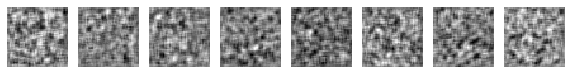

Epoch: 0
Discriminator loss: [0.6875394582748413, 0.1640625]
Generator loss: [0.00019958359189331532, 1.0]


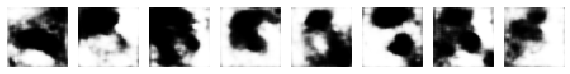

Epoch: 20
Discriminator loss: [0.5798195004463196, 0.5]
Generator loss: [1.3025918006896973, 0.0]


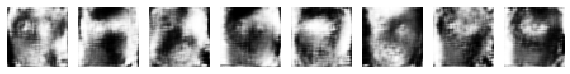

Epoch: 40
Discriminator loss: [0.704113781452179, 0.5]
Generator loss: [1.3277692794799805, 0.0078125]


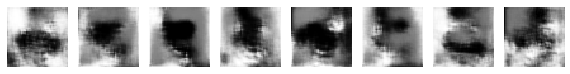

Epoch: 60
Discriminator loss: [0.6741700768470764, 0.5]
Generator loss: [0.9413977265357971, 0.046875]


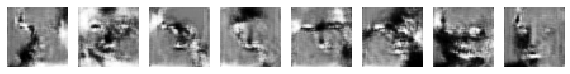

Epoch: 80
Discriminator loss: [0.6966482996940613, 0.296875]
Generator loss: [0.7210943698883057, 0.3125]


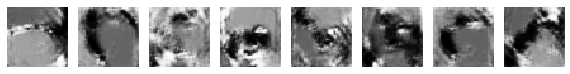

Epoch: 100
Discriminator loss: [0.6714900135993958, 0.42578125]
Generator loss: [0.6985583901405334, 0.484375]


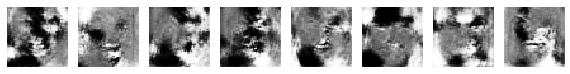

Epoch: 120
Discriminator loss: [0.6105649471282959, 0.48828125]
Generator loss: [0.513767659664154, 0.9375]


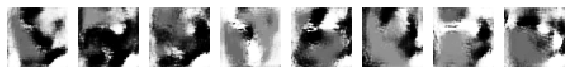

Epoch: 140
Discriminator loss: [0.526145339012146, 0.40234375]
Generator loss: [0.3429771959781647, 0.8359375]


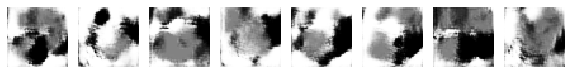

Epoch: 160
Discriminator loss: [0.43782904744148254, 0.4296875]
Generator loss: [0.12476300448179245, 1.0]


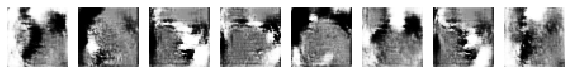

Epoch: 180
Discriminator loss: [0.4702102243900299, 0.453125]
Generator loss: [0.2219211459159851, 1.0]


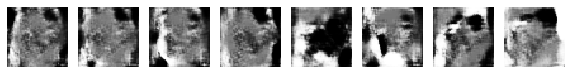

Epoch: 200
Discriminator loss: [0.5081498026847839, 0.4296875]
Generator loss: [0.18402522802352905, 0.9921875]


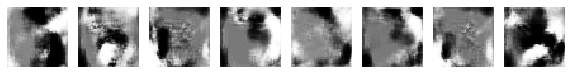

Epoch: 220
Discriminator loss: [0.5541768670082092, 0.41015625]
Generator loss: [0.07147076725959778, 1.0]


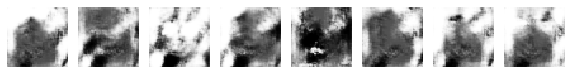

Epoch: 240
Discriminator loss: [0.5330843925476074, 0.4375]
Generator loss: [0.177558034658432, 1.0]


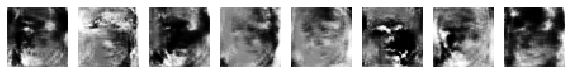

Epoch: 260
Discriminator loss: [0.5133423805236816, 0.30859375]
Generator loss: [0.12588876485824585, 1.0]


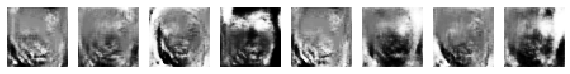

Epoch: 280
Discriminator loss: [0.6521208882331848, 0.44921875]
Generator loss: [0.050560131669044495, 1.0]


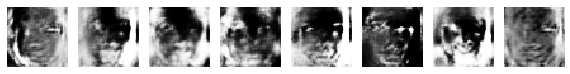

Epoch: 300
Discriminator loss: [0.5624874830245972, 0.41015625]
Generator loss: [0.269760400056839, 0.9921875]


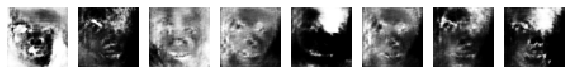

Epoch: 320
Discriminator loss: [0.6019989252090454, 0.37890625]
Generator loss: [0.15825937688350677, 1.0]


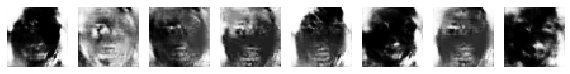

Epoch: 340
Discriminator loss: [0.5546921491622925, 0.33984375]
Generator loss: [0.13601075112819672, 1.0]


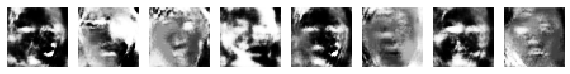

Epoch: 360
Discriminator loss: [0.5734090209007263, 0.3359375]
Generator loss: [0.2736966907978058, 0.9921875]


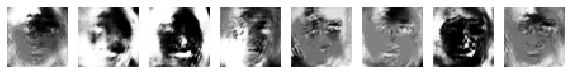

Epoch: 380
Discriminator loss: [0.5640437006950378, 0.3515625]
Generator loss: [0.21347978711128235, 1.0]


In [ ]:
def main():
    # set hyper parameters    
    batch_size = 128
    epochs = 1000
    learning_rate = 0.0002
    z_input_dim = 100
    n_iter_D = 1
    n_iter_G = 5

    # run model
    model = Model(batch_size, epochs, learning_rate, z_input_dim, n_iter_D, n_iter_G)
    model.fit()


if __name__ == '__main__':
    main()